<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [2]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import multistock

from utils import *
from indicators import *
from dataset import Dataset
from forecaster import Forecaster
from solver import Solver
from os.path import join, isfile
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from pandas_datareader import data as pdr
import yfinance as yf

yf.pdr_override()
%matplotlib inline

[*********************100%***********************]  5 of 5 completed


/Users/achar/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


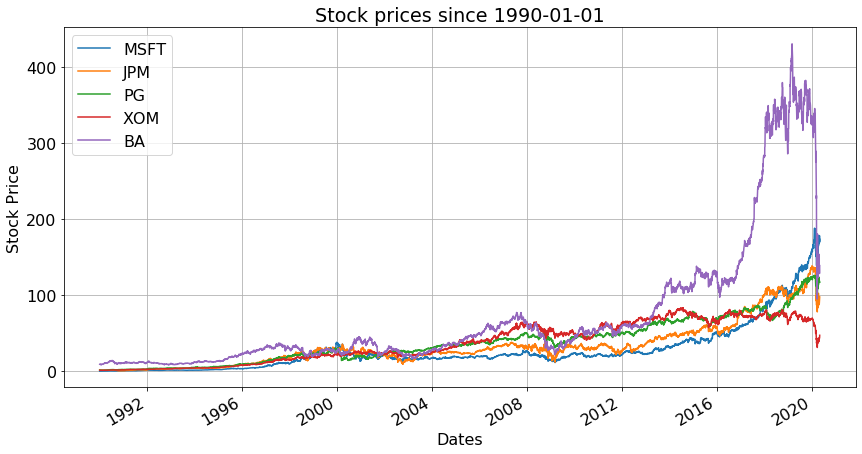

In [3]:
tickers = ['MSFT', 'JPM', 'PG', 'XOM', 'BA']
startdate = "1990-01-01"

df_prices = pdr.get_data_yahoo(tickers, start=startdate, groupby='ticker')

plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(11, 5))
ax = fig.add_axes([0, 0, 1, 1])
for tick in tickers:
    df_prices['Adj Close'][tick].plot(y=tick, ax=ax)

ax.set_xlabel('Dates')
ax.set_ylabel('Stock Price')
ax.set_title('Stock prices since ' + startdate)
ax.legend()
fig.autofmt_xdate(rotation=30)
ax.grid()
plt.tight_layout()
plt.savefig('imgs/stock_prices_since_1990.png')
plt.show()

In [12]:
batch_size = 14
seq_length = 10
test_size = 0.25
predict_ahead = 7
test_size=0.2

# test_type = 'all_stocks'
test_type = 'new_stocks'

technical_indicators = [
    sma,  # Simple Moving Average
    wma,  # Weighted Moving Average
    mom,  # Exponential Moving Average
    macd,  # Moving Average Convergence Divergence
    rsi,  # Relative Strength Indicator
    stoch,  # Stochastic %K and %D
    willr,  # Larry Williams %R
    adosc,  # Accumulation / Distribution Oscillator
#     arima_sma,  # ARIMA on a SMA
#     arima_wma,  # ARIMA on a WMA 
#     arima_ema,  # ARIMA on an EMA
]

# Load parameter file
with open('params/stocks.yaml') as file:
    params = yaml.full_load(file)

multi_features, mulit_labels = multistock.cleanData(df_prices,
                                                    technical_indicators,
                                                    params,
                                                    predict=predict_ahead)

tick = next(iter(multi_features))
n_features = multi_features[tick].shape[1]

features = np.empty(shape=(0, n_features))
for tick in multi_features.keys():
    features = np.concatenate((features, multi_features[tick]))

scaler = StandardScaler()
scaler = scaler.fit(features)

result = multistock.train_test_split(multi_features, mulit_labels, scaler,
                                     seq_length, n_features=n_features, 
                                     test_type=test_type, test_size=test_size)

X_train, X_test, y_train, y_test = result

print('X Train Shape: ', X_train.shape)
print('X Test Shape: ', X_test.shape)
print('Y Train Shape: ', y_train.shape)
print('Y Test Shape: ', y_test.shape)

data_sets = {
    'train': Dataset(X_train, y_train),
    'val': Dataset(X_test, y_test)
}
dataloaders = {
    'train': DataLoader(data_sets['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data_sets['val'], batch_size=1, shuffle=False)
}
dataset_sizes = {x: len(data_sets[x]) for x in ['train', 'val']}

baseline = np.ones_like(y_test)
accuracy = accuracy_score(y_test, baseline)
print(f'Average Baseline Accuracy: {accuracy * 100:.2f}%')

Creating features for BA
Removing 40 rows from data
Creating features for JPM
Removing 40 rows from data
Creating features for MSFT
Removing 40 rows from data
Creating features for PG
Removing 40 rows from data
Creating features for XOM
Removing 40 rows from data
Using XOM data for testing
X Train Shape:  (30368, 10, 10)
X Test Shape:  (7592, 10, 10)
Y Train Shape:  (30368, 1)
Y Test Shape:  (7592, 1)
Average Baseline Accuracy: 57.28%


In [ ]:
model = Forecaster(n_features=n_features, n_hidden=8, n_layers=2, 
                   dropout=0.8)

solver = Solver(model, num_epochs=20, verbose=True, plot=True)
model = solver.train(dataloaders, dataset_sizes)

In [ ]:
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

# Model and no skill guess (always trending up)
y_test, y_pred = solver.eval(model, dataloaders['val'])
ns_pred = np.ones_like(y_pred)

fig = plt.figure(figsize=(14, 6))

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_pred)
ml_fpr, ml_tpr, _ = roc_curve(y_test, y_pred)

plt.subplot(1, 2, 1)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(ml_fpr, ml_tpr, marker='.', label='LSTM Model')
plt.grid()
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

ml_precision, ml_recall, _ = precision_recall_curve(y_test, y_pred)
no_skill = len(y_test[y_test == 1]) / len(y_test)

plt.subplot(1, 2, 2)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(ml_recall, ml_precision, marker='.', label='LSTM Model')
plt.grid()
plt.title('Precision Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# Calculate scores
ns_roc_auc = roc_auc_score(y_test, ns_pred)
ml_roc_auc = roc_auc_score(y_test, y_pred)
ml_pr_auc = auc(ml_recall, ml_precision)

ml_classifications = classify(y_pred, threshold=0.5)
ns_classifications = classify(ns_pred, threshold=0.5)

ns_accuracy = accuracy_score(y_test, ns_classifications)
ns_precision = precision_score(y_test, ns_classifications)
ns_recall = recall_score(y_test, ns_classifications)

ml_accuracy = accuracy_score(y_test, ml_classifications)
ml_precision = precision_score(y_test, ml_classifications)
ml_recall = recall_score(y_test, ml_classifications)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_roc_auc))
print('No Skill: Precision=%.3f' % ns_precision)
print('No Skill: Recall=%.3f' % ns_recall)
print('No Skill: Accuracy=%.3f' % ns_accuracy)
print('-------------------------')
print('LSTM Model: ROC AUC=%.3f' % (ml_roc_auc))
print('LSTM Model: PR AUC=%.3f' % (ml_pr_auc))
print('LSTM Model: Precision=%.3f' % ml_precision)
print('LSTM Model: Recall=%.3f' % ml_recall)
print('LSTM Model: Accuracy=%.3f' % ml_accuracy)

In [13]:
modelparams = {}
modelparams['n_features'] = features.shape[1]
modelparams['n_hidden'] = 8
modelparams['n_layers'] = 2
modelparams['dropout'] = 0.8

solverparams = {}
solverparams['num_epochs'] = 20
solverparams['verbose'] = True
solverparams['plot'] = False

iters=10
threshold=0.5

results = calcMetrics(modelparams, solverparams, dataloaders,
                      dataset_sizes, iters=iters, threshold=threshold)
accuracy, precision, recall = results

print('LSTM Model: Accuracy=%.3f' % accuracy)
print('LSTM Model: Precision=%.3f' % precision)
print('LSTM Model: Recall=%.3f' % recall)

Model Evaluation #1
Using cpu for training.
Epoch: 1-train Loss: 0.6872 Acc: 0.5558
Epoch: 1-val Loss: 0.6839 Acc: 0.5728
Epoch: 2-train Loss: 0.6859 Acc: 0.5609
Epoch: 2-val Loss: 0.6837 Acc: 0.5728
Epoch: 3-train Loss: 0.6858 Acc: 0.5607
Epoch: 3-val Loss: 0.6828 Acc: 0.5728
Epoch: 4-train Loss: 0.6857 Acc: 0.5610
Epoch: 4-val Loss: 0.6831 Acc: 0.5728
Epoch: 5-train Loss: 0.6859 Acc: 0.5609
Epoch: 5-val Loss: 0.6829 Acc: 0.5728
Epoch: 6-train Loss: 0.6857 Acc: 0.5607
Epoch: 6-val Loss: 0.6828 Acc: 0.5728
Epoch: 7-train Loss: 0.6858 Acc: 0.5609
Epoch: 7-val Loss: 0.6826 Acc: 0.5728
Epoch: 8-train Loss: 0.6858 Acc: 0.5609
Epoch: 8-val Loss: 0.6832 Acc: 0.5728
Epoch: 9-train Loss: 0.6858 Acc: 0.5609
Epoch: 9-val Loss: 0.6824 Acc: 0.5728
Epoch: 10-train Loss: 0.6858 Acc: 0.5609
Epoch: 10-val Loss: 0.6830 Acc: 0.5728
Epoch: 11-train Loss: 0.6858 Acc: 0.5609
Epoch: 11-val Loss: 0.6828 Acc: 0.5728
Epoch: 12-train Loss: 0.6857 Acc: 0.5609
Epoch: 12-val Loss: 0.6828 Acc: 0.5728
Epoch: 13-trai

Epoch: 1-train Loss: 0.6859 Acc: 0.5606
Epoch: 1-val Loss: 0.6830 Acc: 0.5728
Epoch: 2-train Loss: 0.6858 Acc: 0.5609
Epoch: 2-val Loss: 0.6827 Acc: 0.5728
Epoch: 3-train Loss: 0.6857 Acc: 0.5609
Epoch: 3-val Loss: 0.6829 Acc: 0.5728
Epoch: 4-train Loss: 0.6857 Acc: 0.5609
Epoch: 4-val Loss: 0.6827 Acc: 0.5728
Epoch: 5-train Loss: 0.6858 Acc: 0.5609
Epoch: 5-val Loss: 0.6828 Acc: 0.5728
Epoch: 6-train Loss: 0.6858 Acc: 0.5609
Epoch: 6-val Loss: 0.6830 Acc: 0.5728
Epoch: 7-train Loss: 0.6858 Acc: 0.5609
Epoch: 7-val Loss: 0.6828 Acc: 0.5728
Epoch: 8-train Loss: 0.6858 Acc: 0.5609
Epoch: 8-val Loss: 0.6827 Acc: 0.5728
Epoch: 9-train Loss: 0.6858 Acc: 0.5609
Epoch: 9-val Loss: 0.6827 Acc: 0.5728
Epoch: 10-train Loss: 0.6858 Acc: 0.5609
Epoch: 10-val Loss: 0.6827 Acc: 0.5728
Epoch: 11-train Loss: 0.6858 Acc: 0.5609
Epoch: 11-val Loss: 0.6829 Acc: 0.5728
Epoch: 12-train Loss: 0.6857 Acc: 0.5609
Epoch: 12-val Loss: 0.6831 Acc: 0.5728
Epoch: 13-train Loss: 0.6858 Acc: 0.5609
Epoch: 13-val Los

In [15]:
print('LSTM Model: Precision=%.3f' % (np.mean(precision) * 100))
print('LSTM Model: Recall=%.3f' % (np.mean(recall) * 100))
print('LSTM Model: Accuracy=%.3f' % (np.mean(accuracy) * 100))

LSTM Model: Precision=57.284
LSTM Model: Recall=100.000
LSTM Model: Accuracy=57.284


In [14]:
ns_pred = np.ones_like(y_test)

ns_classifications = classify(ns_pred, threshold=0.5)
ns_accuracy = accuracy_score(y_test, ns_classifications)
ns_precision = precision_score(y_test, ns_classifications)
ns_recall = recall_score(y_test, ns_classifications)

print('No Skill: Precision=%.3f' % (ns_precision * 100))
print('No Skill: Recall=%.3f' % (ns_recall * 100))
print('No Skill: Accuracy=%.3f' % (ns_accuracy * 100))

No Skill: Precision=57.284
No Skill: Recall=100.000
No Skill: Accuracy=57.284
